In [56]:
from kan import *
import torch
from torch import autograd
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)
np_i = 21 # number of interior points (along each dimension)
np_b = 21 # number of boundary points (along each dimension)
model = KAN(width=[2,2,1])

def interior(nums=np_i):
    x=torch.randn(nums,1)
    y=torch.randn(nums,1)
    return x.requires_grad_(True), y.requires_grad_(True)

def left(nums=np_i):
    y=2*torch.randn(nums,1)-1
    x=torch.zeros_like(y)
    cond=torch.sin(torch.pi*y)*(-1)
    return x.requires_grad_(True), y.requires_grad_(True), cond

def up(nums=np_i):
    x=torch.randn(nums,1)
    y=torch.ones_like(x)
    return x.requires_grad_(True), y.requires_grad_(True)

def down(nums=np_i):
    x=torch.randn(nums,1)
    y=torch.ones_like(x)*(-1)
    return x.requires_grad_(True), y.requires_grad_(True)

def interior_loss(model):
    x,y=interior()
    u=model(torch.hstack([x,y]))
    return torch.mean((gradients(u,x)+u*gradients(u,y)-0.01*gradients(u,y,2)/torch.pi)**2)

def left_loss(model):
    x,y,cond=left()
    u=model(torch.hstack([x,y]))
    return torch.mean((u-cond)**2)

def up_loss(model):
    x,y=up()
    u=model(torch.hstack([x,y]))
    return torch.mean(u**2)

def down_loss(model):
    x,y=down()
    u=model(torch.hstack([x,y]))
    return torch.mean(u**2)

def gradients(u, x, order=1):
    if order==1:
        return autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    else:
        return gradients(gradients(u,x), x, order=order-1)

steps = 50
alpha = 0.01

def train():
    optimizer = LBFGS(model.parameters(), lr=1, line_search_fn="strong_wolfe")

    pbar = tqdm(range(steps), desc='description')

    for _ in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()
            # interior loss
            pde_loss = interior_loss(model)

            # boundary loss
            bc_loss = left_loss(model)+up_loss(model)+down_loss(model)

            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        optimizer.step(closure)
        loss = alpha * pde_loss + bc_loss

        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | loss: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), loss.detach().numpy()))
train()

pde loss: 1.84e-03 | bc loss: 4.75e-01 | loss: 4.75e-01 : 100%|██████████| 50/50 [00:05<00:00,  8.56it/s]


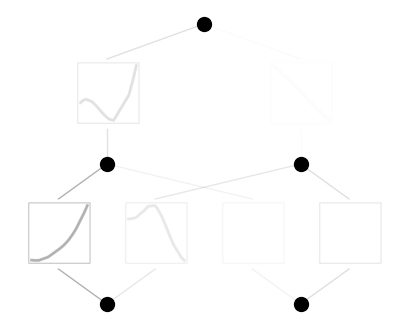

In [57]:
model.plot()

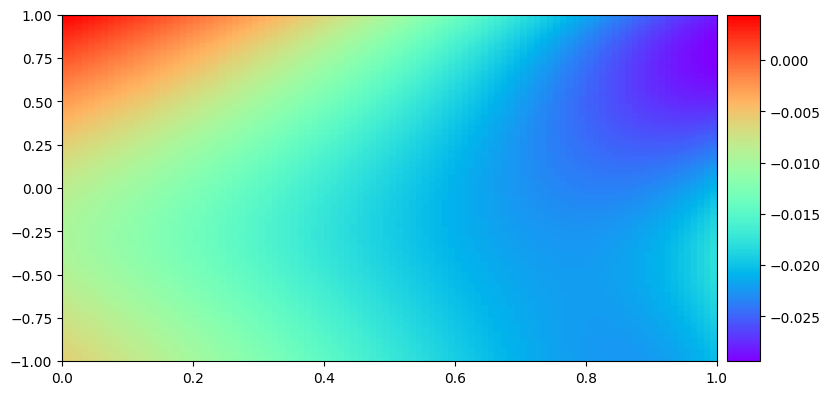

In [58]:
def plot_kan(model):
        """ plot the solution on new data """

        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        x = torch.linspace(-1, 1, 200)
        t = torch.linspace(0, 1, 100)

        # x & t grids:
        X, T = torch.meshgrid(x, t, indexing=None)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        x_i = torch.stack([xcol.reshape(-1,), tcol.reshape(-1,)]).permute(1,0)

        # one large column:
        kan_sol = model(x_i)

        # reshape solution:
        U = kan_sol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()],
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.savefig('./burgers_kan.png')
        plt.show()

plot_kan(model)